# Correlation Analysis

This notebook creates a correlation matrix for the cell types in the dataset.
It then creates a network graph to visualize the correlations between the genes.

In [500]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import scanpy as sc
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
print(ad.__version__)

0.11.4


In [ ]:
# Load young and old data
# cell_types = [
#     "CD8-positive, alpha-beta T cell",
#     "CD8-positive, alpha-beta memory T cell",
#     "CD4-positive, alpha-beta T cell",
#     "central memory CD4-positive, alpha-beta T cell",
#     "effector memory CD4-positive, alpha-beta T cell",
#     "gamma-delta T cell",
#     "regulatory T cell",
#     "double negative T regulatory cell",
#     "innate lymphoid cell"
# ]

cell_type = "innate lymphoid cell"
young_path = "../subsets_9/{}_young_donors.h5ad".format(cell_type)
middle_path = "../subsets_9/{}_middle_donors.h5ad".format(cell_type)
old_path = "../subsets_9/{}_old_donors.h5ad".format(cell_type)
adata_young = ad.read_h5ad(young_path)
adata_middle = ad.read_h5ad(middle_path)
adata_old = ad.read_h5ad(old_path)
print(adata_young)
print(adata_middle)
print(adata_old)

AnnData object with n_obs × n_vars = 42 × 611
    obs: 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intronic_reads_counted', 'library_id', 'assay_ontology_term_id', 'sequenced_fragment', 'cell_number_loaded', 'institute', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'sample_id', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_collection_method', 'donor_BMI_at_collection', 'tissue_type', 'suspension_derivation_process', 'suspension_enriched_cell_types', 'cell_viability_percentage', 'suspension_uuid', 'suspension_type', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Country', 'nCount_RNA', 'nFeature_RNA', 'TCR_VDJdb', 'TCRa_V_gene', 'TCRa_D_gene', 'TCRa_J_gene', 'TCRa_C_gene', 'TCRb_V_gene', 'TCRb_D_gene', 'TCRb_J_gene', 'TCRb_C_gene', 'TCR_Clonality', 'TCR_Clone_ID', 'BC

In [502]:
# Check that every gene is expressed at least once in each dataset in .X
young_check = np.sum(adata_young.X != 0, axis=0)
middle_check = np.sum(adata_middle.X != 0, axis=0)
old_check = np.sum(adata_old.X != 0, axis=0)

# Check that every number in young_check is greater than 0
if np.all(young_check > 0):
    print("All genes expressed at least once in young dataset")

if np.all(middle_check > 0):
    print("All genes expressed at least once in middle dataset")

# Check that every number in old_check is greater than 0
if np.all(old_check > 0):
    print("All genes expressed at least once in old dataset")

All genes expressed at least once in young dataset
All genes expressed at least once in middle dataset
All genes expressed at least once in old dataset


In [503]:
# Get the expression matrix (cells x genes)
expr_matrix = adata_young.X

# Transpose to genes x cells for correlation calculation
expr_matrix = expr_matrix.T

# Calculate correlation matrix (Pearson)
corr_matrix = np.corrcoef(expr_matrix)

# Convert to DataFrame for easier handling
gene_names = adata_young.var_names
corr_df_young = pd.DataFrame(corr_matrix, index=gene_names, columns=gene_names)

In [504]:
# Print the diagonal of the correlation matrix and check for NaN values
print("Diagonal of the correlation matrix (should be 1):")
assert np.isclose(np.diag(corr_df_young.values), 1.0).all()
print("Number of NaN values in the correlation matrix:")
print(np.isnan(corr_df_young.values).sum())

Diagonal of the correlation matrix (should be 1):
Number of NaN values in the correlation matrix:
0


In [505]:
# Print the first few rows of the correlation matrix
print("First few rows of the correlation matrix:")
print(corr_df_young.head())

First few rows of the correlation matrix:
                 ENSG00000116251  ENSG00000215788  ENSG00000074800  \
ENSG00000116251         1.000000         0.202123        -0.025551   
ENSG00000215788         0.202123         1.000000         0.092317   
ENSG00000074800        -0.025551         0.092317         1.000000   
ENSG00000077549         0.104709         0.152751         0.279388   
ENSG00000127483        -0.066749         0.034313         0.185094   

                 ENSG00000077549  ENSG00000127483  ENSG00000070831  \
ENSG00000116251         0.104709        -0.066749         0.432288   
ENSG00000215788         0.152751         0.034313         0.253403   
ENSG00000074800         0.279388         0.185094        -0.057536   
ENSG00000077549         1.000000         0.050217        -0.000105   
ENSG00000127483         0.050217         1.000000        -0.059671   

                 ENSG00000142676  ENSG00000133226  ENSG00000117616  \
ENSG00000116251         0.051005        -0.256

In [506]:
# Get the expression matrix (cells x genes)
expr_matrix = adata_middle.X

# Transpose to genes x cells for correlation calculation
expr_matrix = expr_matrix.T

# Calculate correlation matrix (Pearson)
corr_matrix = np.corrcoef(expr_matrix)

# Convert to DataFrame for easier handling
gene_names = adata_middle.var_names
corr_df_middle = pd.DataFrame(corr_matrix, index=gene_names, columns=gene_names)

In [507]:
# Print the diagonal of the correlation matrix and check for NaN values
print("Diagonal of the correlation matrix (should be 1):")
assert np.isclose(np.diag(corr_df_middle.values), 1.0).all()
print("Number of NaN values in the correlation matrix:")
print(np.isnan(corr_df_middle.values).sum())

Diagonal of the correlation matrix (should be 1):
Number of NaN values in the correlation matrix:
0


In [508]:
# Print the first few rows of the correlation matrix
print("First few rows of the correlation matrix:")
print(corr_df_middle.head())

First few rows of the correlation matrix:
                 ENSG00000116251  ENSG00000215788  ENSG00000074800  \
ENSG00000116251         1.000000         0.100117        -0.086816   
ENSG00000215788         0.100117         1.000000         0.085220   
ENSG00000074800        -0.086816         0.085220         1.000000   
ENSG00000077549        -0.168776         0.231050        -0.244126   
ENSG00000127483        -0.266843         0.015699         0.164755   

                 ENSG00000077549  ENSG00000127483  ENSG00000070831  \
ENSG00000116251        -0.168776        -0.266843        -0.093194   
ENSG00000215788         0.231050         0.015699         0.104957   
ENSG00000074800        -0.244126         0.164755        -0.044885   
ENSG00000077549         1.000000         0.080102         0.068377   
ENSG00000127483         0.080102         1.000000        -0.285592   

                 ENSG00000142676  ENSG00000133226  ENSG00000117616  \
ENSG00000116251        -0.103460        -0.289

In [509]:
# Get the expression matrix for old donors
expr_matrix = adata_old.X

# Transpose to genes x cells for correlation calculation
expr_matrix = expr_matrix.T

# Calculate correlation matrix (Pearson) for old donors
corr_matrix = np.corrcoef(expr_matrix)

# Convert to DataFrame for easier handling
corr_df_old = pd.DataFrame(corr_matrix, index=gene_names, columns=gene_names)

In [510]:
# Print the diagonal of the correlation matrix and check for NaN values
print("Diagonal of the correlation matrix (should be 1):")
assert np.isclose(np.diag(corr_df_old.values), 1.0).all()
print("Number of NaN values in the correlation matrix:")
print(np.isnan(corr_df_old.values).sum())

Diagonal of the correlation matrix (should be 1):
Number of NaN values in the correlation matrix:
0


In [511]:
# Create a difference correlation matrix
def create_difference_correlation_matrix(corr_df1, corr_df2):
    """
    Create a difference correlation matrix between two correlation DataFrames.
    """
    # Ensure both DataFrames have the same index and columns
    assert corr_df1.shape == corr_df2.shape, "DataFrames must have the same shape"
    
    # Calculate the difference
    diff_corr_matrix = corr_df1 - corr_df2
    
    return diff_corr_matrix

# Create difference correlation matrices
diff_corr_young_middle = create_difference_correlation_matrix(corr_df_young, corr_df_middle)
diff_corr_young_old = create_difference_correlation_matrix(corr_df_young, corr_df_old)
diff_corr_middle_old = create_difference_correlation_matrix(corr_df_middle, corr_df_old)

# Assert that all difference correlation matrices have zero diagonal
assert np.all(diff_corr_young_middle.values.diagonal() <= 1e-10), "Diagonal of difference correlation matrix should be zero"


In [512]:
# Find the top 10 genes pairs with the largest absolute difference in correlation
top_diff_genes = diff_corr_young_old.abs().unstack().sort_values(ascending=False)


In [513]:
print("Top 10 gene pairs with the largest absolute difference in correlation:")
print(top_diff_genes.head(10))

Top 10 gene pairs with the largest absolute difference in correlation:
ENSG00000051523  ENSG00000137154    1.319248
ENSG00000137154  ENSG00000051523    1.319248
ENSG00000125740  ENSG00000197061    1.286339
ENSG00000197061  ENSG00000125740    1.286339
ENSG00000108107  ENSG00000177954    1.214680
ENSG00000177954  ENSG00000108107    1.214680
ENSG00000227507  ENSG00000160888    1.214258
ENSG00000160888  ENSG00000227507    1.214258
ENSG00000099783  ENSG00000152795    1.212363
ENSG00000152795  ENSG00000099783    1.212363
dtype: float64


In [514]:
# Create a excel file with the same information for the top 10 gene pairs 
# The columns would be gene1, gene2, correlation difference, correlation in young, correlation in middle, correlation in old
top_diff_genes_df = pd.DataFrame(top_diff_genes, columns=["Correlation Difference"])
top_diff_genes_df.reset_index(inplace=True)
top_diff_genes_df.columns = ["Gene1", "Gene2", "Correlation Difference"]

# Add correlation values from young, middle, and old datasets
top_diff_genes_df["Correlation Young"] = top_diff_genes_df.apply(lambda x: corr_df_young.loc[x["Gene1"], x["Gene2"]], axis=1)
top_diff_genes_df["Correlation Middle"] = top_diff_genes_df.apply(lambda x: corr_df_middle.loc[x["Gene1"], x["Gene2"]], axis=1)
top_diff_genes_df["Correlation Old"] = top_diff_genes_df.apply(lambda x: corr_df_old.loc[x["Gene1"], x["Gene2"]], axis=1)
# Save to Excel
path = "results/{}_top_diff_genes.xlsx".format(cell_type)
top_diff_genes_df.to_excel(path, index=False)

In [515]:
# Calculate the z value for the correlation coefficients of the two datasets
def fisher_z_transform(r):
    """Fisher Z transformation."""
    return 0.5 * np.log((1 + r) / (1 - r))

n1 = adata_young.shape[0]  # Number of donors in young dataset
n2 = adata_middle.shape[0]  # Number of donors in middle dataset
n3 = adata_old.shape[0]  # Number of donors in old dataset

SE_diff_young_middle = np.sqrt((1 / (n1 - 3)) + (1 / (n2 - 3)))  # Standard error of the difference
SE_diff_middle_old = np.sqrt((1 / (n2 - 3)) + (1 / (n3 - 3)))  # Standard error of the difference
SE_diff_young_old = np.sqrt((1 / (n1 - 3)) + (1 / (n3 - 3)))  # Standard error of the difference

gene_names = adata_young.var_names

z_diff_young_middle = fisher_z_transform(corr_df_young) - fisher_z_transform(corr_df_middle)
z_diff_middle_old = fisher_z_transform(corr_df_middle) - fisher_z_transform(corr_df_old)
z_diff_young_old = fisher_z_transform(corr_df_young) - fisher_z_transform(corr_df_old)

# Zet all the diagonal values to 0
for i in range(z_diff_young_middle.shape[0]):
    z_diff_young_middle.values[i, i] = 0
    z_diff_middle_old.values[i, i] = 0
    z_diff_young_old.values[i, i] = 0


# Count the number of NaN values
num_nan = np.isnan(z_diff_young_middle).sum().sum()
num_nan2 = np.isnan(z_diff_middle_old).sum().sum()
num_nan3 = np.isnan(z_diff_young_old).sum().sum()
print("Number of NaN values in z_diff:", num_nan, num_nan2, num_nan3)
# Count the number of infinite values
num_inf = np.isinf(z_diff_young_middle).sum().sum()
num_inf2 = np.isinf(z_diff_middle_old).sum().sum()
num_inf3 = np.isinf(z_diff_young_old).sum().sum()
print("Number of infinite values in z_diff:", num_inf, num_inf2, num_inf3)

# Turn the z_diff into a DataFrame
z_diff_young_middle = pd.DataFrame(z_diff_young_middle, index=gene_names, columns=gene_names)
z_diff_middle_old = pd.DataFrame(z_diff_middle_old, index=gene_names, columns=gene_names)
z_diff_young_old = pd.DataFrame(z_diff_young_old, index=gene_names, columns=gene_names)

z_diff_young_middle /= SE_diff_young_middle
z_diff_middle_old /= SE_diff_middle_old
z_diff_young_old /= SE_diff_young_old

# Print the shape of the z_diff matrix
print("Shape of the z_diff matrix:")
print(z_diff_young_middle.shape)

Number of NaN values in z_diff: 0 0 0
Number of infinite values in z_diff: 0 0 0
Shape of the z_diff matrix:
(611, 611)


In [516]:
# Find the top 10 genes with the largest absolute z-scores
top_genes = z_diff_young_old.abs().unstack().sort_values(ascending=False)

print("Top 10 genes with the largest absolute z-scores:")
print(top_genes.head(10))

Top 10 genes with the largest absolute z-scores:
ENSG00000137154  ENSG00000051523    5.608684
ENSG00000051523  ENSG00000137154    5.608684
ENSG00000125740  ENSG00000197061    4.926899
ENSG00000197061  ENSG00000125740    4.926899
ENSG00000169813  ENSG00000144655    4.776349
ENSG00000144655  ENSG00000169813    4.776349
ENSG00000177954  ENSG00000108107    4.743516
ENSG00000108107  ENSG00000177954    4.743516
ENSG00000168685  ENSG00000134333    4.740009
ENSG00000134333  ENSG00000168685    4.740009
dtype: float64


In [517]:
# We define a significant difference as |Z| > 2.576 or p < 0.01
# This corresponds to a 99% confidence interval for a two-tailed test
significant_diff = 2.576

# We want to create a network of genes with a significant difference in correlation between young and old donors
# So we want to make a list of all the genes and for every gene we want a list with all the genes that are significantly different
# in correlation with that gene so for example if gene A has a significant difference in correlation with gene B and gene C
# we want to add B and C to the list of gene A [A: [B, C]]
# We will use a dictionary to store the results
significant_diff_dict = {}
for gene in gene_names:
    # Get the differences in correlation for the current gene
    diff_for_gene = z_diff_young_middle[gene]
    diff_for_gene2 = z_diff_middle_old[gene]
    diff_for_gene3 = z_diff_young_old[gene]
    
    # Find genes with significant differences
    significant_genes = diff_for_gene[diff_for_gene.abs() > significant_diff].index.tolist()
    significant_genes2 = diff_for_gene2[diff_for_gene2.abs() > significant_diff].index.tolist()
    significant_genes3 = diff_for_gene3[diff_for_gene3.abs() > significant_diff].index.tolist()

    # Intersect the lists to find genes that are significantly different in all three comparisons
    significant_genes_final = list(set(significant_genes) & set(significant_genes2) & set(significant_genes3))
    # significant_genes_final = significant_genes3
    
    # Store the results in the dictionary
    significant_diff_dict[gene] = significant_genes_final

In [518]:
# Plot the genes with the most significant differences
# We will plot the top 10 genes with the most significant differences in the dictionary
top_genes = sorted(significant_diff_dict.items(), key=lambda x: len(x[1]), reverse=True)


In [519]:
print("Top 10 gene pairs with the most amount of difference in correlation:")
top_genes_replace_list_with_length = {}
for gene, diff_genes in top_genes:
    top_genes_replace_list_with_length[gene] = len(diff_genes)


for gene, diff_genes in top_genes[:12]:
    print(f"{gene}: {len(diff_genes)}")

# Plot the top 10 genes with the least significant differences in the dictionary
print("Top 10 gene pairs with the least amount of differences in correlation:")
for gene, diff_genes in top_genes[-10:]:
    print(f"{gene}: {len(diff_genes)}")


# Count the total number of connections in the network
total_connections = sum(len(diff_genes) for diff_genes in significant_diff_dict.values())

twenty_percent = int(0.2 * len(top_genes))
print("Twenty percent of the top genes:", twenty_percent)

# Count the total number of connections in the network for the top 120 genes
total_connections_top_120 = 0
for gene, diff_genes in top_genes[:twenty_percent]:
    total_connections_top_120 += len(diff_genes)

print("Total number of connections in the network:", total_connections)
print("Total number of connections in the network for the top", twenty_percent, "genes:", total_connections_top_120)

# Print if the pareto principle applies
if total_connections_top_120 / total_connections > 0.8:
    print("The pareto principle applies: ", total_connections_top_120 / total_connections)
else:
    print("The pareto principle does not apply: ", total_connections_top_120 / total_connections)




# Write the total_connections to a excel file the columns are gene and number of significant differences
significant_diff_df = pd.DataFrame.from_dict(top_genes_replace_list_with_length, orient='index', columns=['Number of Significant Differences'])
# Reset the index to have gene names as a column
significant_diff_df.reset_index(inplace=True)
# Rename the columns
significant_diff_df.columns = ['Gene', 'Number of Significant Differences']
# Save to Excel
path = "results/network/all_groups/{}_significant_differences.xlsx".format(cell_type)
significant_diff_df.to_excel(path, index=False)

Top 10 gene pairs with the most amount of difference in correlation:
ENSG00000034510: 1
ENSG00000169567: 1
ENSG00000148362: 1
ENSG00000169100: 1
ENSG00000116251: 0
ENSG00000215788: 0
ENSG00000074800: 0
ENSG00000077549: 0
ENSG00000127483: 0
ENSG00000070831: 0
ENSG00000142676: 0
ENSG00000133226: 0
Top 10 gene pairs with the least amount of differences in correlation:
ENSG00000198712: 0
ENSG00000228253: 0
ENSG00000198899: 0
ENSG00000198938: 0
ENSG00000198840: 0
ENSG00000212907: 0
ENSG00000198886: 0
ENSG00000198786: 0
ENSG00000198695: 0
ENSG00000198727: 0
Twenty percent of the top genes: 122
Total number of connections in the network: 4
Total number of connections in the network for the top 122 genes: 4
The pareto principle applies:  1.0


In [520]:
# Print the genes of the first gene
print(top_genes[0])

top_genes_dict = {}
for gene, diff_genes in top_genes:
    top_genes_dict[gene] = diff_genes

# Convert the dictionary into a DataFrame
df = pd.DataFrame({
    "Gene": top_genes_dict.keys(),
    "Associated Genes": top_genes_dict.values()
})

# Write to Excel
path = "results/network/all_groups/{}_gene_associations.xlsx".format(cell_type)
df.to_excel(path, index=False)

print("Excel file saved successfully!")

('ENSG00000034510', ['ENSG00000148362'])
Excel file saved successfully!


In [521]:
# Create a visualization of the network
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph (since correlations may be asymmetric)
G = nx.DiGraph()

# Add nodes (genes)
G.add_nodes_from(gene_names)

# Add edges based on significant_diff_dict
for gene, connected_genes in significant_diff_dict.items():
    for target_gene in connected_genes:
        G.add_edge(gene, target_gene)

# Optional: Print basic graph info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Turn the graph to an undirected graph
G = G.to_undirected()

Number of nodes: 611
Number of edges: 4


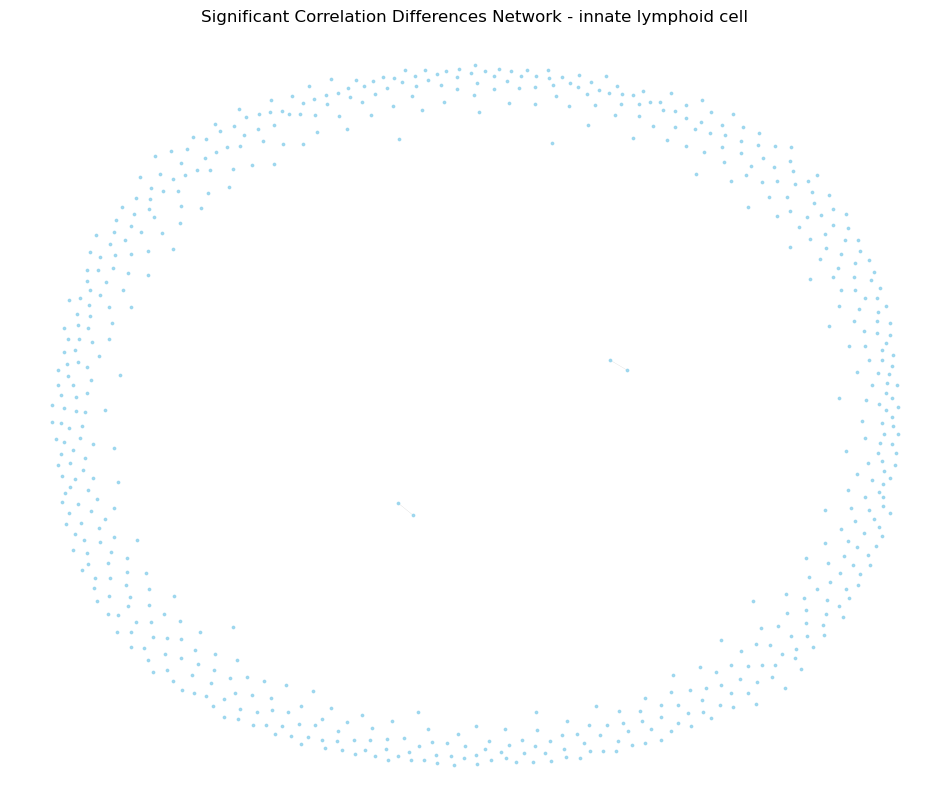

In [522]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.15, iterations=50)  # Force-directed layout
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=False,
    node_size=3,
    node_color="skyblue",
    width=0.1,
    edge_color="gray",
    font_size=1,
    alpha=0.7,
)
plt.title(f"Significant Correlation Differences Network - {cell_type}")
plt.axis("off")
plt.show()

In [523]:
# We define a significant difference as |Z| > 2.576 or p < 0.01
# This corresponds to a 99% confidence interval for a two-tailed test
significant_diff = 2.576

# We want to create a network of genes with a significant difference in correlation between young and old donors
# So we want to make a list of all the genes and for every gene we want a list with all the genes that are significantly different
# in correlation with that gene so for example if gene A has a significant difference in correlation with gene B and gene C
# we want to add B and C to the list of gene A [A: [B, C]]
# We will use a dictionary to store the results
significant_diff_dict = {}
for gene in gene_names:
    # Get the differences in correlation for the current gene
    diff_for_gene = z_diff_young_old[gene]
    
    # Find genes with significant differences
    significant_genes_final = diff_for_gene[diff_for_gene.abs() > significant_diff].index.tolist()
    
    # Store the results in the dictionary
    significant_diff_dict[gene] = significant_genes_final

In [524]:
# Plot the genes with the most significant differences
# We will plot the top 10 genes with the most significant differences in the dictionary
top_genes = sorted(significant_diff_dict.items(), key=lambda x: len(x[1]), reverse=True)


In [525]:
print("Top 10 gene pairs with the most amount of difference in correlation:")
top_genes_replace_list_with_length = {}
for gene, diff_genes in top_genes:
    top_genes_replace_list_with_length[gene] = len(diff_genes)


for gene, diff_genes in top_genes[:12]:
    print(f"{gene}: {len(diff_genes)}")

# Plot the top 10 genes with the least significant differences in the dictionary
print("Top 10 gene pairs with the least amount of differences in correlation:")
for gene, diff_genes in top_genes[-10:]:
    print(f"{gene}: {len(diff_genes)}")


# Count the total number of connections in the network
total_connections = sum(len(diff_genes) for diff_genes in significant_diff_dict.values())

twenty_percent = int(0.2 * len(top_genes))
print("Twenty percent of the top genes:", twenty_percent)

# Count the total number of connections in the network for the top 120 genes
total_connections_top_120 = 0
for gene, diff_genes in top_genes[:twenty_percent]:
    total_connections_top_120 += len(diff_genes)

print("Total number of connections in the network:", total_connections)
print("Total number of connections in the network for the top", twenty_percent, "genes:", total_connections_top_120)

# Print if the pareto principle applies
if total_connections_top_120 / total_connections > 0.8:
    print("The pareto principle applies: ", total_connections_top_120 / total_connections)
else:
    print("The pareto principle does not apply: ", total_connections_top_120 / total_connections)




# Write the total_connections to a excel file the columns are gene and number of significant differences
significant_diff_df = pd.DataFrame.from_dict(top_genes_replace_list_with_length, orient='index', columns=['Number of Significant Differences'])
# Reset the index to have gene names as a column
significant_diff_df.reset_index(inplace=True)
# Rename the columns
significant_diff_df.columns = ['Gene', 'Number of Significant Differences']
# Save to Excel
path = "results/network/young_old/{}_significant_differences.xlsx".format(cell_type)
significant_diff_df.to_excel(path, index=False)

Top 10 gene pairs with the most amount of difference in correlation:
ENSG00000148303: 32
ENSG00000134333: 32
ENSG00000213145: 32
ENSG00000105404: 31
ENSG00000168685: 30
ENSG00000197061: 30
ENSG00000135046: 30
ENSG00000131143: 30
ENSG00000169442: 29
ENSG00000152795: 29
ENSG00000111348: 29
ENSG00000147168: 29
Top 10 gene pairs with the least amount of differences in correlation:
ENSG00000240972: 4
ENSG00000115053: 3
ENSG00000145425: 3
ENSG00000057608: 3
ENSG00000233927: 3
ENSG00000100129: 3
ENSG00000135426: 2
ENSG00000265681: 2
ENSG00000123144: 2
ENSG00000125384: 1
Twenty percent of the top genes: 122
Total number of connections in the network: 8088
Total number of connections in the network for the top 122 genes: 2728
The pareto principle does not apply:  0.33728981206726016


In [526]:
# Print the genes of the first gene
print(top_genes[0])

top_genes_dict = {}
for gene, diff_genes in top_genes:
    top_genes_dict[gene] = diff_genes

# Convert the dictionary into a DataFrame
df = pd.DataFrame({
    "Gene": top_genes_dict.keys(),
    "Associated Genes": top_genes_dict.values()
})

# Write to Excel
path = "results/network/young_old/{}_gene_associations.xlsx".format(cell_type)
df.to_excel(path, index=False)

print("Excel file saved successfully!")

('ENSG00000148303', ['ENSG00000077549', 'ENSG00000142676', 'ENSG00000177954', 'ENSG00000143947', 'ENSG00000170144', 'ENSG00000082153', 'ENSG00000162244', 'ENSG00000144746', 'ENSG00000163682', 'ENSG00000152795', 'ENSG00000145703', 'ENSG00000124614', 'ENSG00000156508', 'ENSG00000112695', 'ENSG00000197448', 'ENSG00000067167', 'ENSG00000165280', 'ENSG00000150093', 'ENSG00000110321', 'ENSG00000251562', 'ENSG00000139644', 'ENSG00000100664', 'ENSG00000103653', 'ENSG00000102879', 'ENSG00000109062', 'ENSG00000104964', 'ENSG00000105583', 'ENSG00000132002', 'ENSG00000130522', 'ENSG00000083845', 'ENSG00000159140', 'ENSG00000100219'])
Excel file saved successfully!


In [527]:
# Create a visualization of the network
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph (since correlations may be asymmetric)
G = nx.DiGraph()

# Add nodes (genes)
G.add_nodes_from(gene_names)

# Add edges based on significant_diff_dict
for gene, connected_genes in significant_diff_dict.items():
    for target_gene in connected_genes:
        G.add_edge(gene, target_gene)

# Optional: Print basic graph info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Turn the graph to an undirected graph
G = G.to_undirected()

Number of nodes: 611
Number of edges: 8088


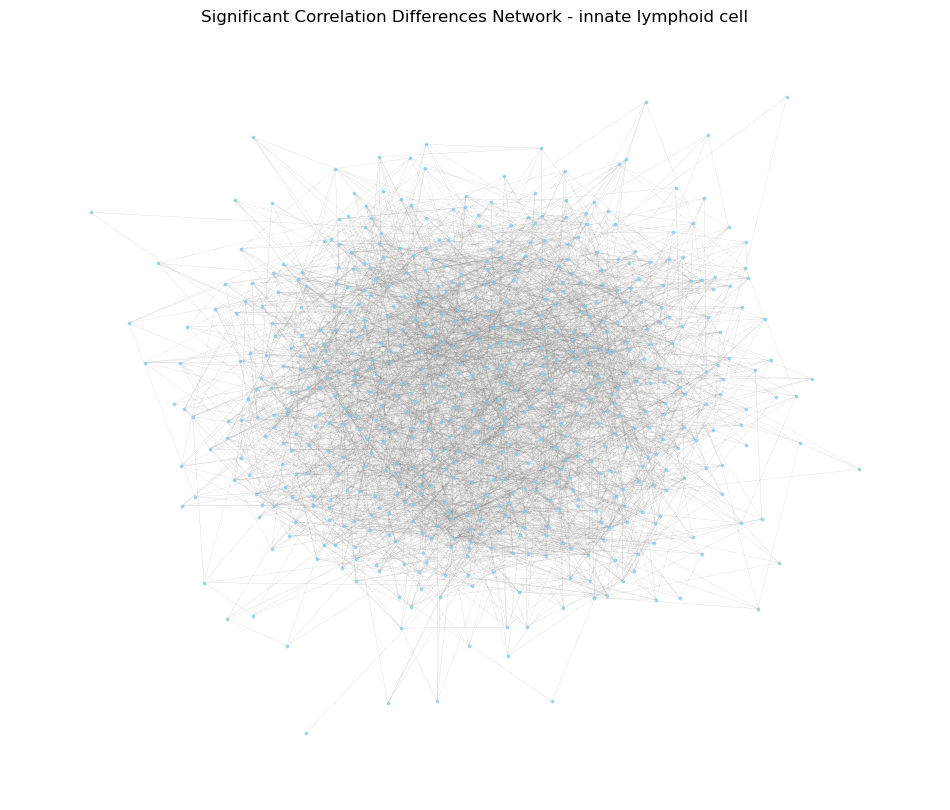

In [528]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.15, iterations=50)  # Force-directed layout
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=False,
    node_size=3,
    node_color="skyblue",
    width=0.1,
    edge_color="gray",
    font_size=1,
    alpha=0.7,
)
plt.title(f"Significant Correlation Differences Network - {cell_type}")
plt.axis("off")
plt.show()